## Import libraries


In [1]:
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchsummary import summary
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import warnings
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import random_split, DataLoader
from collections import Counter

warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

C:\Users\pancz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


## 1. Dataset


#### Splitting the dataset, Pre-processing the dataset (data loader with transformations)

In [2]:
data_dir = 'Dataset\images'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

# Create the train_dataset using ImageFolder.
train_dataset = ImageFolder(data_dir, transform=transform)

total_samples = len(train_dataset)
train_size = int(0.35 * total_samples)
val_size = int(0.35 * total_samples)
test_size = total_samples - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(train_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Loading one example for each object type from the dataset

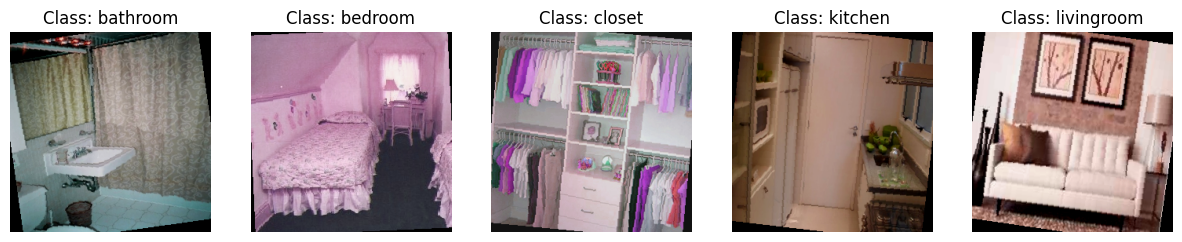

In [3]:
def show_samples_with_class_names(dataset, class_names):
    num_classes = len(class_names)
    fig, axs = plt.subplots(1, num_classes, figsize=(15, 3))

    for i in range(num_classes):
        for j in range(len(dataset)):
            image, label = dataset[j]
            if label == i:
                class_name = class_names[label]
                axs[i].imshow(image.permute(1, 2, 0))
                axs[i].set_title(f"Class: {class_name}")
                axs[i].axis('off')
                break

class_names = ['bathroom', 'bedroom', 'closet', 'kitchen', 'livingroom']

show_samples_with_class_names(train_dataset, class_names)

#### Check the number of images and class balances in the  train, validation and test set

In [4]:
class_distribution = Counter([item[1] for item in train_dataset])
print("Class distribution in the training set:", class_distribution)

Class distribution in the training set: Counter({3: 264, 4: 234, 1: 226, 2: 45, 0: 45})


## 2. Convolutional Neural Network Architecture

#### Load the given pre-trained model

In [5]:
model = models.mobilenet_v2(pretrained=True)

#### Summary of the given pre-trained model

In [6]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
             ReLU6-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
             ReLU6-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]             512
       BatchNorm2d-8         [-1, 16, 128, 128]              32
  InvertedResidual-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 96, 128, 128]           1,536
      BatchNorm2d-11         [-1, 96, 128, 128]             192
            ReLU6-12         [-1, 96, 128, 128]               0
           Conv2d-13           [-1, 96, 64, 64]             864
      BatchNorm2d-14           [-1, 96,

#### Implement the new architecture with less parameter

In [7]:
num_features = model.classifier[1].in_features

num_classes = 5
classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5), 
    nn.Linear(512, num_classes) 
)

model.classifier = classifier

model.train()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

#### Summary of the new architecture

In [8]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
             ReLU6-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
             ReLU6-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]             512
       BatchNorm2d-8         [-1, 16, 128, 128]              32
  InvertedResidual-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 96, 128, 128]           1,536
      BatchNorm2d-11         [-1, 96, 128, 128]             192
            ReLU6-12         [-1, 96, 128, 128]               0
           Conv2d-13           [-1, 96, 64, 64]             864
      BatchNorm2d-14           [-1, 96,

## 3. Training

Define your loss function

In [9]:
criterion = nn.CrossEntropyLoss()

#### Define your optimizer

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#### Train your network

In [11]:
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = float('inf')
patience = 10
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
weight_decay = 1e-4

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        for param in model.parameters():
            loss += weight_decay * torch.sum(param ** 2)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    for images, labels in val_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping. Restoring best model.")
        model.load_state_dict(torch.load('best_model.pth'))
        break

    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    scheduler.step()


Epoch [1/20] - Train Loss: 64.9890, Train Accuracy: 35.75%
Validation Loss: 35.3781, Validation Accuracy: 53.07%
Epoch [2/20] - Train Loss: 59.8660, Train Accuracy: 50.37%
Validation Loss: 31.6028, Validation Accuracy: 60.57%
Epoch [3/20] - Train Loss: 55.2008, Train Accuracy: 61.30%
Validation Loss: 26.6939, Validation Accuracy: 62.53%
Epoch [4/20] - Train Loss: 50.5675, Train Accuracy: 65.11%
Validation Loss: 22.2835, Validation Accuracy: 67.32%
Epoch [5/20] - Train Loss: 47.1176, Train Accuracy: 69.16%
Validation Loss: 19.3984, Validation Accuracy: 70.88%
Epoch [6/20] - Train Loss: 44.8413, Train Accuracy: 72.48%
Validation Loss: 19.1233, Validation Accuracy: 71.38%
Epoch [7/20] - Train Loss: 44.8143, Train Accuracy: 73.46%
Validation Loss: 19.0087, Validation Accuracy: 72.11%
Epoch [8/20] - Train Loss: 44.2858, Train Accuracy: 74.69%
Validation Loss: 18.4482, Validation Accuracy: 73.71%
Epoch [9/20] - Train Loss: 43.7864, Train Accuracy: 74.32%
Validation Loss: 18.3785, Validation 

#### Show the loss on training and validation sets

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


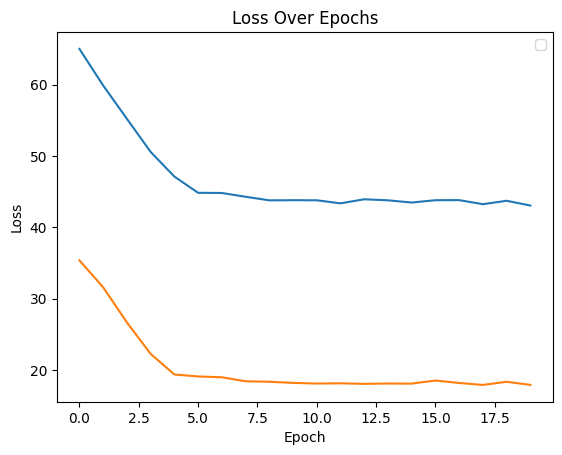

In [13]:
plt.plot(torch.tensor(train_losses, device = 'cpu'))
plt.plot(torch.tensor(val_losses, device = 'cpu'))
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### Show the accuracy on training and validation sets

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


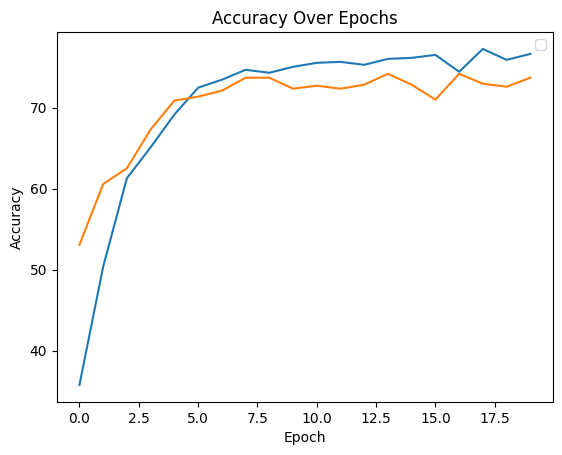

In [14]:
plt.plot(torch.tensor(train_accuracies, device = 'cpu'))
plt.plot(torch.tensor(val_accuracies, device = 'cpu'))
plt.legend()
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#### Save your trained CNN

In [15]:
torch.save(model.state_dict(), 'your_model.pth')

## 4. Evaluation and Testing

#### Evaluate your model

In [16]:
model.load_state_dict(torch.load('your_model.pth'))
model.eval()

model_predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        model_predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

correct_predictions = (np.array(model_predictions) == np.array(true_labels)).sum()
test_accuracy = correct_predictions / len(true_labels)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.7349570200573066


#### Show the test accuracy next to the training and validation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


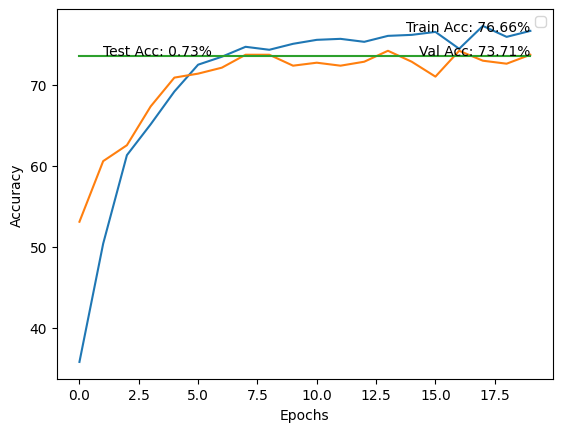

Final Training Accuracy: 76.66%
Final Validation Accuracy: 73.71%
Test Accuracy: 0.73%


In [17]:
plt.plot(torch.tensor(train_accuracies, device = 'cpu'))
plt.plot(torch.tensor(val_accuracies, device = 'cpu'))
plt.plot(torch.tensor(test_accuracy, device = 'cpu')*100*np.ones(len(val_accuracies)))

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.text(len(train_accuracies) - 1, train_accuracies[-1], f'Train Acc: {train_accuracies[-1]:.2f}%', ha='right')
plt.text(len(val_accuracies) - 1, val_accuracies[-1], f'Val Acc: {val_accuracies[-1]:.2f}%', ha='right')
plt.text(1, val_accuracies[-1], f'Test Acc: {test_accuracy:.2f}%')

plt.show()

print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

#### Confusion matrix

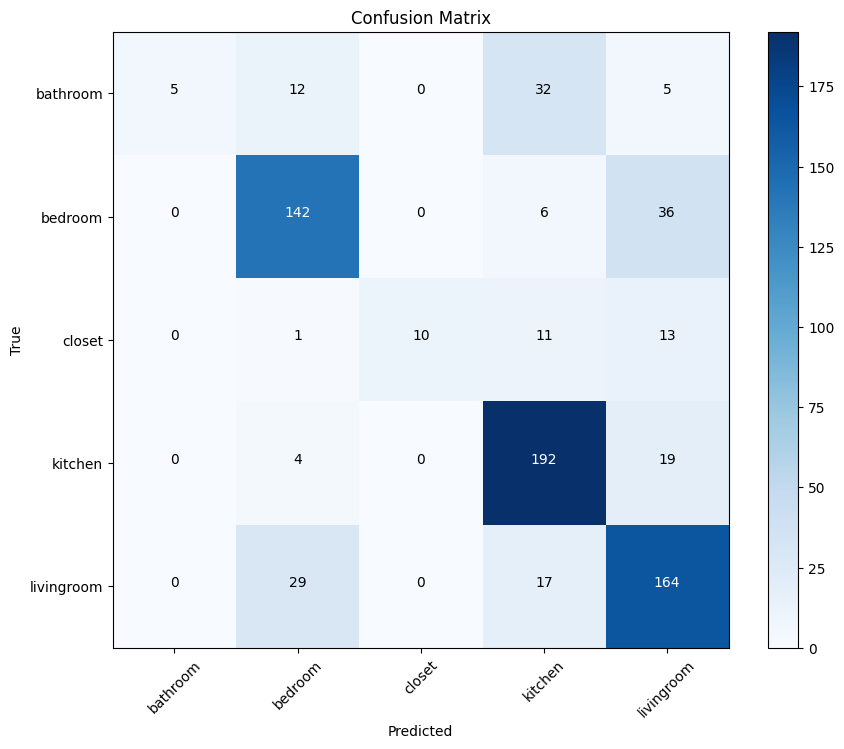

In [18]:
def calculate_confusion_matrix(true_labels, model_predictions, class_names):
    num_classes = len(class_names)
    confusion_mat = np.zeros((num_classes, num_classes), dtype=np.int)
    for i in range(len(true_labels)):
        true_label = true_labels[i]
        predicted_label = model_predictions[i]
        confusion_mat[true_label][predicted_label] += 1
    return confusion_mat


confusion_mat = calculate_confusion_matrix(true_labels, model_predictions, class_names)

plt.figure(figsize=(10, 8))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)

plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = confusion_mat.max() / 2.
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, format(confusion_mat[i, j], 'd'), horizontalalignment="center", color="white" if confusion_mat[i, j] > thresh else "black")

plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


#### Show some predictions

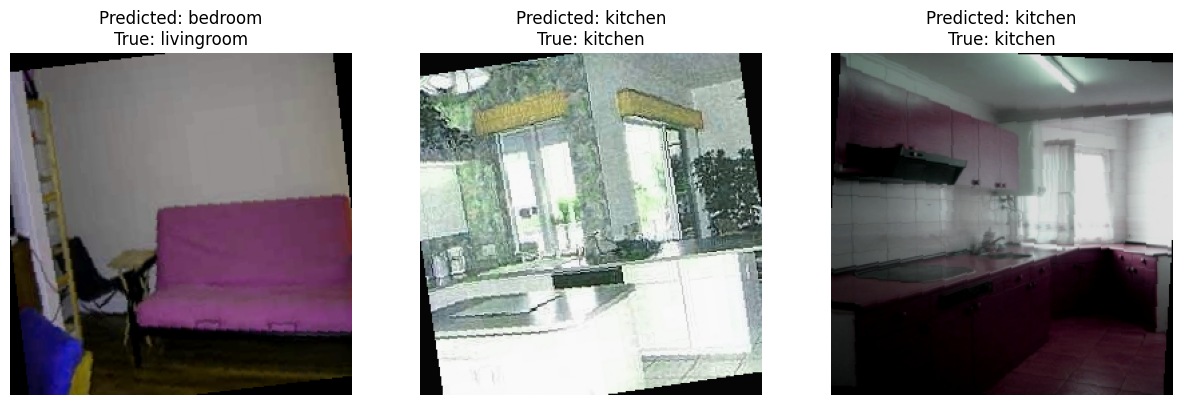

In [21]:
num_samples=3
model.eval()

def show_predictions(model, test_loader, num_samples):
    model.eval()
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))
    class_names = ['bathroom', 'bedroom', 'closet', 'kitchen', 'livingroom']
    for i in range(num_samples):
        random_idx = random.randint(0, len(test_loader.dataset) - 1)
        image, label = test_loader.dataset[random_idx]
        class_name = class_names[label]
        with torch.no_grad():
            output = model(image.unsqueeze(0))
        predicted_label = torch.argmax(output).item()
        
        axs[i].imshow(image.permute(1, 2, 0))
        axs[i].set_title(f"Predicted: {class_names[predicted_label]}\nTrue: {class_name}")
        axs[i].axis('off')

show_predictions(model, test_loader, num_samples)


#### Missed predictions

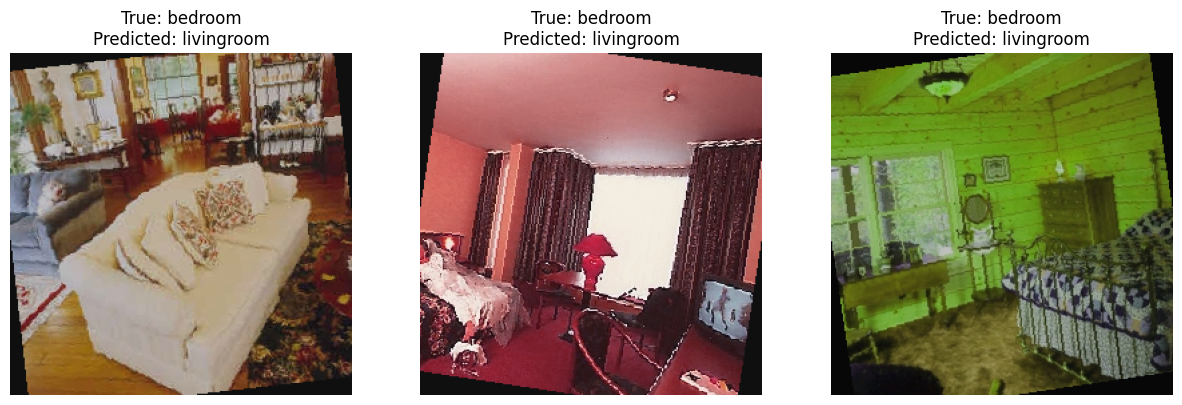

In [20]:
num_samples=3

def show_missed_predictions(model, test_loader, class_names, num_samples):
    model.eval()
    missed_samples = []
    for i in range(len(test_loader.dataset)):
        image, label = test_loader.dataset[i]
        with torch.no_grad():
            output = model(image.unsqueeze(0)) 
        predicted_label = torch.argmax(output).item()
        if predicted_label != label:
            missed_samples.append((image, class_names[label], class_names[predicted_label]))

        if len(missed_samples) >= num_samples:
            break

    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(len(missed_samples)):
        image, true_label, predicted_label = missed_samples[i]
        axs[i].imshow(image.permute(1, 2, 0)) 
        axs[i].set_title(f"True: {true_label}\nPredicted: {predicted_label}")
        axs[i].axis('off')

show_missed_predictions(model, test_loader, class_names, num_samples)
